## Importance sampling (avec les mains)

*Billet écrit sur une idée de Jérôme M. ; le notebook original est disponible [ici](https://github.com/xoolive/xoolive.github.io/raw/master/notebooks/2017-05-11-importance-sampling.ipynb)*.

Une des manières d'estimer l'aire d'un cercle est de tirer au hasard $n$ échantillons sur $[-1, 1]^2$ et de compter le nombres d'échantillons dont la norme est inférieure à 1. En réalité, quand on dit au hasard, on entend « suivant une loi uniforme » :

3.1400000000000001

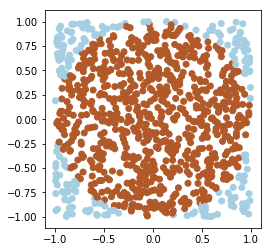

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

n_samples = 1000
x = np.random.uniform(-1, 1, size=(n_samples, 2))
plt.scatter(*x.T, c=np.sum(x**2, axis=1) < 1, cmap='Paired')
plt.axis('scaled')

sum(np.sum(x**2, axis=1) < 1)/n_samples * 4

On peut généraliser cette approche à plus de dimensions. Il est confortable pour nos comparaisons de connaître la valeur exacte du volume d'une hypersphère en dimension $n$:

In [2]:
import math

def volume(n):
    return math.pi ** (n/2) / math.gamma(n/2 + 1)

def monte_carlo(n, n_samples=100000):
    x = np.random.uniform(-1, 1, size=(n_samples, n))
    return sum((x**2).sum(axis=1) < 1)/n_samples * 2**n

On peut tracer le volume de l'hypersphère en fonction du nombre de dimensions : le volume croît jusqu'à la dimension 5 puis décroît pour tendre vers 0.

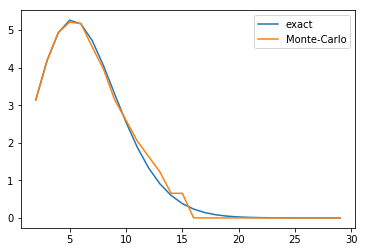

In [3]:
range_n = list(range(2, 30))
exact_n = np.asarray([volume(n) for n in range_n])
monte_carlo_n = np.asarray([monte_carlo(n) for n in range_n])

plt.plot(range_n, exact_n, label='exact')
plt.plot(range_n, monte_carlo_n, label='Monte-Carlo')
plt.legend(loc='best')

Il semble que l'approximation ne soit pas très heureuse pour les grandes dimensions, mais traçons plutôt l'erreur relative (échelle semilog) qui met bien en valeur les limites de la méthode pour les grandes dimensions.

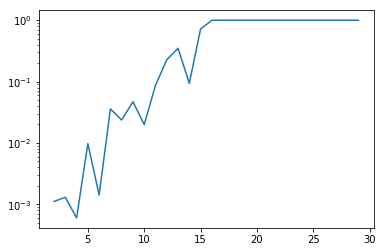

In [4]:
plt.semilogy(range_n, np.abs(monte_carlo_n - exact_n)/exact_n)

L'erreur vient de la superposition de plusieurs phénomènes :

 - le volume de l'hypersphère décroît fortement avec la dimension ;
 - la malédiction de la dimension (*curse of dimensionality*) : les échantillons se retrouvent « isolés » et deviennent épars, ce qui est problématique pour ce genre de méthode qui nécessite un nombre significatif de données pour être valide ;
 - en tirant des échantillons selon une loi uniforme sur plusieurs dimensions, on augmente nos chances d'être extrême suivant une des dimensions, et par conséquent d'être hors de l'hypersphère.
 
Une manière de pallier ce problème est de tirer plus d'échantillons près du centre, dans la zone où l'indicatrice a plus de chances d'être valide. On peut utiliser alors une [loi bêta](https://fr.wikipedia.org/wiki/Loi_b%C3%AAta), définie entre 0 et 1, qui dépend de deux paramètres, et dont la densité de probabilité est présentée ci-dessous.

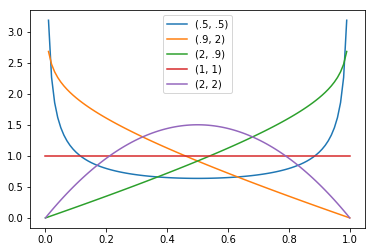

In [5]:
from scipy.stats import beta

x = np.linspace(0, 1, 100)

plt.plot(x, beta.pdf(x, .5, .5), label="(.5, .5)")
plt.plot(x, beta.pdf(x, .9, 2), label="(.9, 2)")
plt.plot(x, beta.pdf(x, 2, .9), label="(2, .9)")
plt.plot(x, beta.pdf(x, 1, 1), label="(1, 1)")
plt.plot(x, beta.pdf(x, 2, 2), label="(2, 2)")

plt.legend(loc='best')

La loi bêta$-(1, 1)$ est une loi uniforme ; nous nous intéressons aux lois bêta$-(k, k)$, avec $k > 1$.

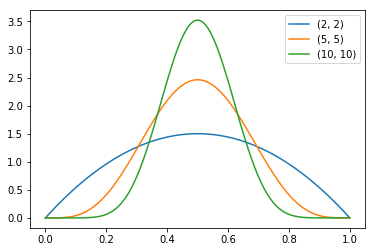

In [6]:
plt.plot(x, beta.pdf(x, 2, 2), label="(2, 2)")
plt.plot(x, beta.pdf(x, 5, 5), label="(5, 5)")
plt.plot(x, beta.pdf(x, 10, 10), label="(10, 10)")
plt.legend(loc="best")

En échantillonnant de préférence plus près du centre de l'intervalle, il convient de corriger l'indicatrice par un facteur multiplicatif qui dépend de la densité de probabilité de chaque échantillon tiré suivant la loi bêta. Avec $k=1$, on retombe sur une distribution uniforme comme dans l'exemple précédent.

In [7]:
def monte_carlo_beta(n, k=2, n_samples=100000):
    x = np.random.beta(k, k, size=(n_samples, n))
    b = beta.pdf(x, k, k)
    x = 2*x - 1  # center on [-1, 1]
    return sum(((x**2).sum(axis=1) < 1) / np.product(b, axis=1))/n_samples * 2**n 

En dimension 2, le nouvel échantillonnage est parlant sur l'affichage suivant:

3.0640523136345106

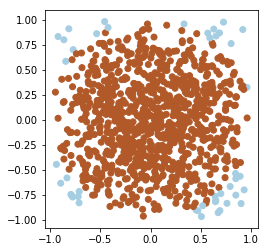

In [8]:
n_samples = 1000
x = np.random.beta(2, 2, size=(n_samples, 2))
b = beta.pdf(x, 2, 2)
x = 2*x -1
plt.scatter(*x.T, c=np.sum(x**2, axis=1) < 1, cmap='Paired')
plt.axis('scaled')

sum(((x**2).sum(axis=1) < 1) / np.product(b, axis=1))/n_samples * 4

Le même tracé pour l'hypersphère en dimension n semble meilleur.

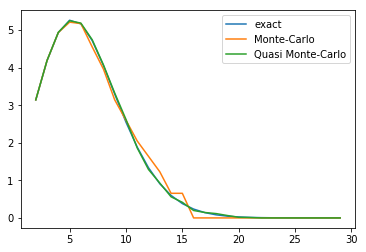

In [9]:
monte_carlo_beta_2 = np.asarray([monte_carlo_beta(n) for n in range_n])

plt.plot(range_n, exact_n, label='exact')
plt.plot(range_n, monte_carlo_n, label='Monte-Carlo')
plt.plot(range_n, monte_carlo_beta_2, label='Quasi Monte-Carlo')

plt.legend(loc='best')

En erreur relative, la méthode avec échantillonnage suivant une loi bêta$-(2, 2)$ est moins bonne sur les petites dimensions, mais meilleure sur les grandes.

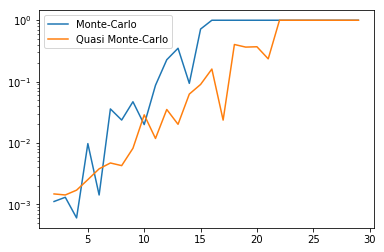

In [10]:
plt.semilogy(range_n, np.abs(monte_carlo_n - exact_n)/exact_n,
             label="Monte-Carlo")
plt.semilogy(range_n, np.abs(monte_carlo_beta_2 - exact_n)/exact_n,
             label="Quasi Monte-Carlo")

plt.legend(loc="best")

En revanche, elle est toujours mauvaise sur les dimensions supérieures à 20. On peut alors encore jouer sur les paramètres de la loi bêta :

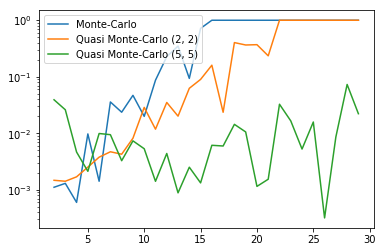

In [11]:
monte_carlo_beta_5 = np.asarray([monte_carlo_beta(n, 5) for n in range_n])

plt.semilogy(range_n, np.abs(monte_carlo_n - exact_n)/exact_n,
             label="Monte-Carlo")
plt.semilogy(range_n, np.abs(monte_carlo_beta_2 - exact_n)/exact_n,
             label="Quasi Monte-Carlo (2, 2)")
plt.semilogy(range_n, np.abs(monte_carlo_beta_5 - exact_n)/exact_n,
             label="Quasi Monte-Carlo (5, 5)")

plt.legend(loc="best")